In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from kerastuner.tuners import BayesianOptimization
from tensorflow.python.client import device_lib
import sklearn 
from sklearn.model_selection import train_test_split
%matplotlib inline
tf.test.is_built_with_cuda()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### regularizing_BN

In [87]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# load and preprocess dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# model
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(8, activation='relu',kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.1),
                         kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax',kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.1))
])

# compile model
model.compile(optimizer='SGD',loss='categorical_crossentropy',metrics=['accuracy'])

# define batch size and number of epochs
BATCH_SIZE = 128
EPOCHS = 50

# create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

# define loss function and optimization algorithm
loss_func = tf.keras.losses.CategoricalCrossentropy()
optimization = tf.keras.optimizers.SGD(learning_rate=0.01)

# initialize lists for tracking training progress
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(EPOCHS):
    train_loss = tf.keras.metrics.Mean()
    train_acc = tf.keras.metrics.CategoricalAccuracy()
    val_loss = tf.keras.metrics.Mean()
    val_acc = tf.keras.metrics.CategoricalAccuracy()

    # train on batches
    for step, (batch_x, batch_y) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            # compute predictions and loss
            logits = model(batch_x, training=True)
            loss = loss_func(batch_y, logits)
        # compute gradients and update model parameters
        gradients = tape.gradient(loss, model.trainable_variables)
        optimization.apply_gradients(zip(gradients, model.trainable_variables))
        # update training metrics
        train_loss.update_state(loss)
        train_acc.update_state(batch_y, logits)

    # evaluate on validation set
    for batch_x, batch_y in test_dataset:
        logits = model(batch_x, training=False)
        loss = loss_func(batch_y, logits)
        val_loss.update_state(loss)
        val_acc.update_state(batch_y, logits)

    # record epoch metrics
    train_loss_list.append(train_loss.result().numpy())
    train_acc_list.append(train_acc.result().numpy())
    val_loss_list.append(val_loss.result().numpy())
    val_acc_list.append(val_acc.result().numpy())

    # print epoch summary
    print(f"Epoch {epoch+1}:")
    print(f"  Training Loss: {train_loss.result():.4f}")
    print(f"  Training Accuracy: {train_acc.result():.4f}")
    print(f"  Validation Loss: {val_loss.result():.4f}")
    print(f"  Validation Accuracy: {val_acc.result():.4f}")


Epoch 1:
  Training Loss: 1.8579
  Training Accuracy: 0.3913
  Validation Loss: 1.4170
  Validation Accuracy: 0.5914
Epoch 2:
  Training Loss: 1.1596
  Training Accuracy: 0.6869
  Validation Loss: 0.8699
  Validation Accuracy: 0.7690
Epoch 3:
  Training Loss: 0.7792
  Training Accuracy: 0.7905
  Validation Loss: 0.6433
  Validation Accuracy: 0.8228
Epoch 4:
  Training Loss: 0.6214
  Training Accuracy: 0.8268
  Validation Loss: 0.5390
  Validation Accuracy: 0.8494
Epoch 5:
  Training Loss: 0.5393
  Training Accuracy: 0.8469
  Validation Loss: 0.4782
  Validation Accuracy: 0.8638
Epoch 6:
  Training Loss: 0.4901
  Training Accuracy: 0.8604
  Validation Loss: 0.4398
  Validation Accuracy: 0.8765
Epoch 7:
  Training Loss: 0.4554
  Training Accuracy: 0.8692
  Validation Loss: 0.4121
  Validation Accuracy: 0.8848
Epoch 8:
  Training Loss: 0.4333
  Training Accuracy: 0.8762
  Validation Loss: 0.3948
  Validation Accuracy: 0.8871
Epoch 9:
  Training Loss: 0.4136
  Training Accuracy: 0.8803
  V

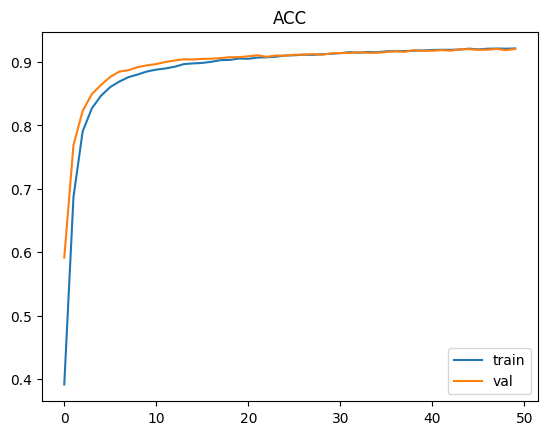

In [88]:
plt.plot(np.arange(0,len(train_acc_list)), train_acc_list, label='train')
plt.plot(np.arange(0,len(val_acc_list)), val_acc_list, label='val')
plt.title(label='ACC')
plt.legend()
plt.show()

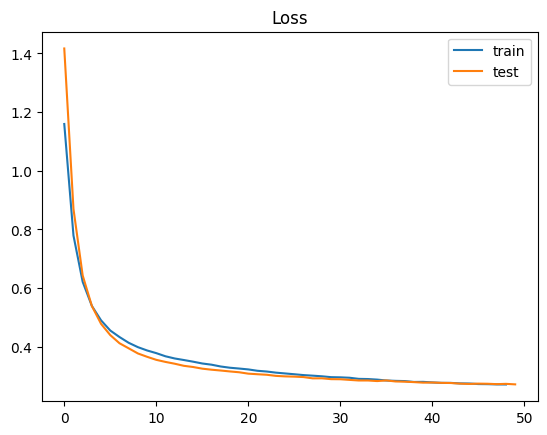

In [89]:
plt.plot(np.arange(0,len(train_loss_list[1:])), train_loss_list[1:], label='train')
plt.plot(np.arange(0,len(val_loss_list)), val_loss_list, label='test')
plt.title(label='Loss')
plt.legend()
plt.show()

### regularizing_DO

In [90]:
# model
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(8, activation='relu',kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.1),
                         kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax',kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.1))
])



# define batch size and number of epochs
BATCH_SIZE = 128
EPOCHS = 50

# create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

# define loss function and optimization algorithm
loss_func = tf.keras.losses.CategoricalCrossentropy()
optimization = tf.keras.optimizers.SGD(learning_rate=0.01)

# initialize lists for tracking training progress
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(EPOCHS):
    train_loss = tf.keras.metrics.Mean()
    train_acc = tf.keras.metrics.CategoricalAccuracy()
    val_loss = tf.keras.metrics.Mean()
    val_acc = tf.keras.metrics.CategoricalAccuracy()

    # train on batches
    for step, (batch_x, batch_y) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            # compute predictions and loss
            logits = model(batch_x, training=True)
            loss = loss_func(batch_y, logits)
        # compute gradients and update model parameters
        gradients = tape.gradient(loss, model.trainable_variables)
        optimization.apply_gradients(zip(gradients, model.trainable_variables))
        # update training metrics
        train_loss.update_state(loss)
        train_acc.update_state(batch_y, logits)

    # evaluate on validation set
    for batch_x, batch_y in test_dataset:
        logits = model(batch_x, training=False)
        loss = loss_func(batch_y, logits)
        val_loss.update_state(loss)
        val_acc.update_state(batch_y, logits)

    # record epoch metrics
    train_loss_list.append(train_loss.result().numpy())
    train_acc_list.append(train_acc.result().numpy())
    val_loss_list.append(val_loss.result().numpy())
    val_acc_list.append(val_acc.result().numpy())

    # print epoch summary
    print(f"Epoch {epoch+1}:")
    print(f"  Training Loss: {train_loss.result():.4f}")
    print(f"  Training Accuracy: {train_acc.result():.4f}")
    print(f"  Validation Loss: {val_loss.result():.4f}")
    print(f"  Validation Accuracy: {val_acc.result():.4f}")

Epoch 1:
  Training Loss: 2.1416
  Training Accuracy: 0.2139
  Validation Loss: 1.8681
  Validation Accuracy: 0.3758
Epoch 2:
  Training Loss: 1.6807
  Training Accuracy: 0.4186
  Validation Loss: 1.2902
  Validation Accuracy: 0.6754
Epoch 3:
  Training Loss: 1.3243
  Training Accuracy: 0.5631
  Validation Loss: 0.9619
  Validation Accuracy: 0.7519
Epoch 4:
  Training Loss: 1.1339
  Training Accuracy: 0.6217
  Validation Loss: 0.7961
  Validation Accuracy: 0.8000
Epoch 5:
  Training Loss: 1.0318
  Training Accuracy: 0.6503
  Validation Loss: 0.7000
  Validation Accuracy: 0.8250
Epoch 6:
  Training Loss: 0.9785
  Training Accuracy: 0.6636
  Validation Loss: 0.6424
  Validation Accuracy: 0.8369
Epoch 7:
  Training Loss: 0.9267
  Training Accuracy: 0.6795
  Validation Loss: 0.6020
  Validation Accuracy: 0.8490
Epoch 8:
  Training Loss: 0.8922
  Training Accuracy: 0.6909
  Validation Loss: 0.5698
  Validation Accuracy: 0.8546
Epoch 9:
  Training Loss: 0.8738
  Training Accuracy: 0.6955
  V

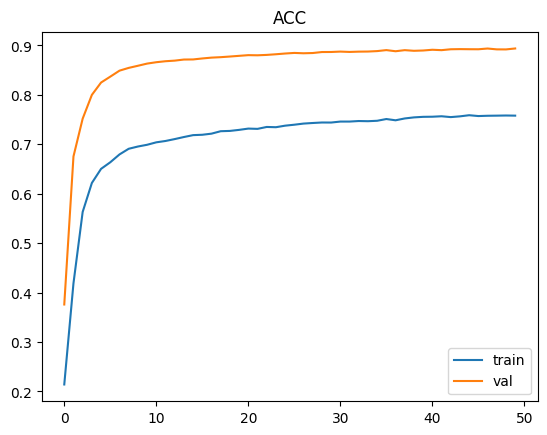

In [91]:
plt.plot(np.arange(0,len(train_acc_list)), train_acc_list, label='train')
plt.plot(np.arange(0,len(val_acc_list)), val_acc_list, label='val')
plt.title(label='ACC')
plt.legend()
plt.show()

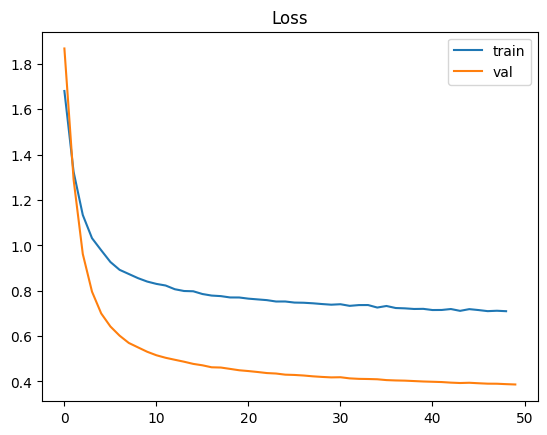

In [92]:
plt.plot(np.arange(0,len(train_loss_list[1:])), train_loss_list[1:], label='train')
plt.plot(np.arange(0,len(val_loss_list)), val_loss_list, label='val')
plt.title(label='Loss')
plt.legend()
plt.show()

### weight tuning_r_EB

In [93]:

# Define the loss function with enet regularization
def loss_function(y_true, y_pred):
    ce_loss = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
    l1_loss = tf.reduce_mean(tf.abs(y_true - y_pred))
    l2_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    loss = 0.5 * l1_loss + 0.5 * l2_loss
    total_loss = ce_loss + loss
    return total_loss

# define your model
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(8, activation='relu',kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.1),
                         kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dense(10, activation='softmax',kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.1))
])


# define hyperparameters
EPOCHS = 50
BATCH_SIZE = 128
# define loss function and optimizer
loss_func = loss_function
optimization = tf.keras.optimizers.SGD(learning_rate=0.01)

# initialize lists for tracking training progress
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(EPOCHS):
    train_loss = tf.keras.metrics.Mean()
    train_acc = tf.keras.metrics.CategoricalAccuracy()
    val_loss = tf.keras.metrics.Mean()
    val_acc = tf.keras.metrics.CategoricalAccuracy()

    # train on batches
    for step, (batch_x, batch_y) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            # compute predictions and loss
            logits = model(batch_x, training=True)
            loss = loss_func(batch_y, logits)
        # compute gradients and update model parameters
        gradients = tape.gradient(loss, model.trainable_variables)
        optimization.apply_gradients(zip(gradients, model.trainable_variables))
        # update training metrics
        train_loss.update_state(loss)
        train_acc.update_state(batch_y, logits)

    # evaluate on validation set
    for batch_x, batch_y in test_dataset:
        logits = model(batch_x, training=False)
        loss = loss_func(batch_y, logits)
        val_loss.update_state(loss)
        val_acc.update_state(batch_y, logits)

    # record epoch metrics
    train_loss_list.append(train_loss.result().numpy())
    train_acc_list.append(train_acc.result().numpy())
    val_loss_list.append(val_loss.result().numpy())
    val_acc_list.append(val_acc.result().numpy())

    # print epoch summary
    print(f"Epoch {epoch+1}:")
    print(f"  Training Loss: {train_loss.result():.4f}")
    print(f"  Training Accuracy: {train_acc.result():.4f}")
    print(f"  Validation Loss: {val_loss.result():.4f}")
    print(f"  Validation Accuracy: {val_acc.result():.4f}")



Epoch 1:
  Training Loss: 2.2830
  Training Accuracy: 0.2478
  Validation Loss: 1.9737
  Validation Accuracy: 0.4086
Epoch 2:
  Training Loss: 1.5066
  Training Accuracy: 0.5942
  Validation Loss: 1.0930
  Validation Accuracy: 0.7316
Epoch 3:
  Training Loss: 0.9025
  Training Accuracy: 0.7689
  Validation Loss: 0.7365
  Validation Accuracy: 0.8045
Epoch 4:
  Training Loss: 0.6847
  Training Accuracy: 0.8168
  Validation Loss: 0.6056
  Validation Accuracy: 0.8330
Epoch 5:
  Training Loss: 0.5896
  Training Accuracy: 0.8403
  Validation Loss: 0.5353
  Validation Accuracy: 0.8524
Epoch 6:
  Training Loss: 0.5335
  Training Accuracy: 0.8554
  Validation Loss: 0.4910
  Validation Accuracy: 0.8642
Epoch 7:
  Training Loss: 0.4950
  Training Accuracy: 0.8666
  Validation Loss: 0.4591
  Validation Accuracy: 0.8711
Epoch 8:
  Training Loss: 0.4668
  Training Accuracy: 0.8748
  Validation Loss: 0.4359
  Validation Accuracy: 0.8778
Epoch 9:
  Training Loss: 0.4455
  Training Accuracy: 0.8800
  V

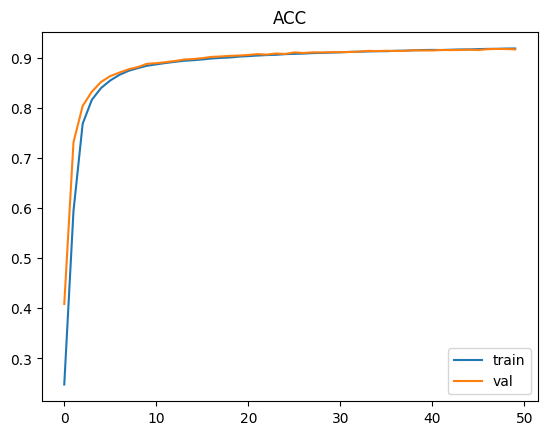

In [94]:
plt.plot(np.arange(0,len(train_acc_list)), train_acc_list, label='train')
plt.plot(np.arange(0,len(val_acc_list)), val_acc_list, label='val')
plt.title(label='ACC')
plt.legend()
plt.show()

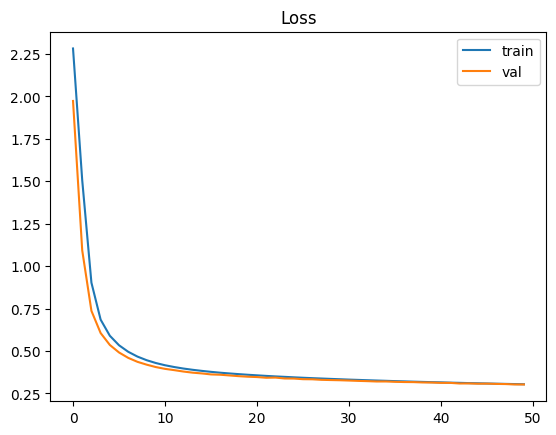

In [95]:
plt.plot(np.arange(0,len(train_loss_list)), train_loss_list, label='train')
plt.plot(np.arange(0,len(val_loss_list)), val_loss_list, label='val')
plt.title(label='Loss')
plt.legend()
plt.show()

### r_EB_LG

In [96]:
device = "cuda" if tf.config.list_physical_devices('GPU') else "cpu"

EPSILONONE=2e-1
L2_Lambda = 0.001
BOUND = 50
EPSILON = 8e-2
EPOCH = 50

In [97]:
# define your model
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(8, activation='relu',kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.1),
                         kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dense(10, activation='softmax',kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.1))
])


Epoch 1:
  Training Loss: 2.1751
  Training Accuracy: 0.3216
  Validation Loss: 1.7406
  Validation Accuracy: 0.5200
Epoch 2:
  Training Loss: 1.3094
  Training Accuracy: 0.6400
  Validation Loss: 0.9651
  Validation Accuracy: 0.7370
Epoch 3:
  Training Loss: 0.8584
  Training Accuracy: 0.7628
  Validation Loss: 0.7355
  Validation Accuracy: 0.7947
Epoch 4:
  Training Loss: 0.7038
  Training Accuracy: 0.8037
  Validation Loss: 0.6332
  Validation Accuracy: 0.8265
Epoch 5:
  Training Loss: 0.6235
  Training Accuracy: 0.8283
  Validation Loss: 0.5736
  Validation Accuracy: 0.8429
Epoch 6:
  Training Loss: 0.5729
  Training Accuracy: 0.8428
  Validation Loss: 0.5315
  Validation Accuracy: 0.8520
Epoch 7:
  Training Loss: 0.5368
  Training Accuracy: 0.8536
  Validation Loss: 0.5027
  Validation Accuracy: 0.8608
Epoch 8:
  Training Loss: 0.5088
  Training Accuracy: 0.8616
  Validation Loss: 0.4754
  Validation Accuracy: 0.8687
Epoch 9:
  Training Loss: 0.4848
  Training Accuracy: 0.8690
  V

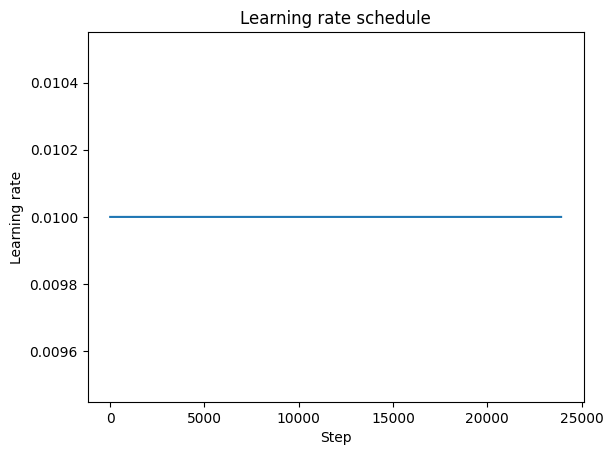

In [98]:
# define hyperparameters
EPOCHS = 200
BATCH_SIZE = 128
EPSILON = 1e-4
BOUND = 50

# define loss function and optimizer
loss_func = loss_function
optimization = tf.keras.optimizers.SGD(learning_rate=0.01)

# initialize lists for tracking training progress
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
lr_list = []

for epoch in range(EPOCHS):
    train_loss = tf.keras.metrics.Mean()
    train_acc = tf.keras.metrics.CategoricalAccuracy()
    val_loss = tf.keras.metrics.Mean()
    val_acc = tf.keras.metrics.CategoricalAccuracy()

    # train on batches
    for step, (batch_x, batch_y) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            # compute predictions and loss
            logits = model(batch_x, training=True)
            loss = loss_func(batch_y, logits)
        # compute gradients and update model parameters
        gradients = tape.gradient(loss, model.trainable_variables)
        optimization.apply_gradients(zip(gradients, model.trainable_variables))
        # update training metrics
        train_loss.update_state(loss)
        train_acc.update_state(batch_y, logits)
        lr_list.append(optimization.learning_rate.numpy())

    # evaluate on validation set
    for batch_x, batch_y in test_dataset:
        logits = model(batch_x, training=False)
        loss = loss_func(batch_y, logits)
        val_loss.update_state(loss)
        val_acc.update_state(batch_y, logits)

    # record epoch metrics
    train_loss_list.append(train_loss.result().numpy())
    train_acc_list.append(train_acc.result().numpy())
    val_loss_list.append(val_loss.result().numpy())
    val_acc_list.append(val_acc.result().numpy())

    # print epoch summary
    print(f"Epoch {epoch+1}:")
    print(f"  Training Loss: {train_loss.result():.4f}")
    print(f"  Training Accuracy: {train_acc.result():.4f}")
    print(f"  Validation Loss: {val_loss.result():.4f}")
    print(f"  Validation Accuracy: {val_acc.result():.4f}")
    
    # check if learning goal is achieved
    lg = 0
    for x, y in train_dataset:
        logits = model(x, training=False)
        loss = loss_func(y, logits)
        lg += loss.numpy()
    if lg/(len(train_dataset)*BATCH_SIZE) < EPSILON or epoch >= BOUND:
        break

# plot learning rate schedule
plt.plot(lr_list)
plt.title('Learning rate schedule')
plt.xlabel('Step')
plt.ylabel('Learning rate')
plt.show()


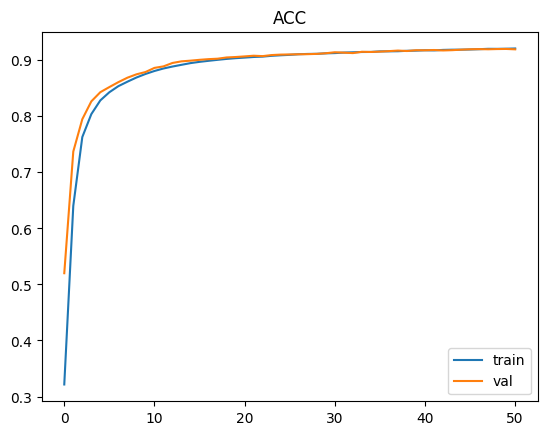

In [99]:
plt.plot(np.arange(0,len(train_acc_list)), train_acc_list, label='train')
plt.plot(np.arange(0,len(val_acc_list)), val_acc_list, label='val')
plt.title(label='ACC')
plt.legend()
plt.show()

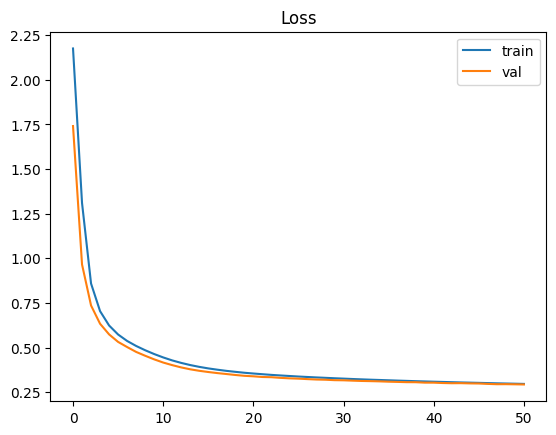

In [100]:
plt.plot(np.arange(0,len(train_loss_list)), train_loss_list, label='train')
plt.plot(np.arange(0,len(val_loss_list)), val_loss_list, label='val')
plt.title(label='Loss')
plt.legend()
plt.show()

### r_LG_UA

Epoch 1:
  Training Loss: 0.2950
  Training Accuracy: 0.9213
  Validation Loss: 0.2914
  Validation Accuracy: 0.9196
Epoch 2:
  Training Loss: 0.2943
  Training Accuracy: 0.9212
  Validation Loss: 0.2905
  Validation Accuracy: 0.9214
Epoch 3:
  Training Loss: 0.2932
  Training Accuracy: 0.9215
  Validation Loss: 0.2908
  Validation Accuracy: 0.9208
Epoch 4:
  Training Loss: 0.2921
  Training Accuracy: 0.9212
  Validation Loss: 0.2880
  Validation Accuracy: 0.9209
Epoch 5:
  Training Loss: 0.2905
  Training Accuracy: 0.9224
  Validation Loss: 0.2876
  Validation Accuracy: 0.9214
Epoch 6:
  Training Loss: 0.2892
  Training Accuracy: 0.9227
  Validation Loss: 0.2855
  Validation Accuracy: 0.9209
Epoch 7:
  Training Loss: 0.2876
  Training Accuracy: 0.9229
  Validation Loss: 0.2846
  Validation Accuracy: 0.9223
Epoch 8:
  Training Loss: 0.2854
  Training Accuracy: 0.9238
  Validation Loss: 0.2830
  Validation Accuracy: 0.9220
Epoch 9:
  Training Loss: 0.2835
  Training Accuracy: 0.9237
  V

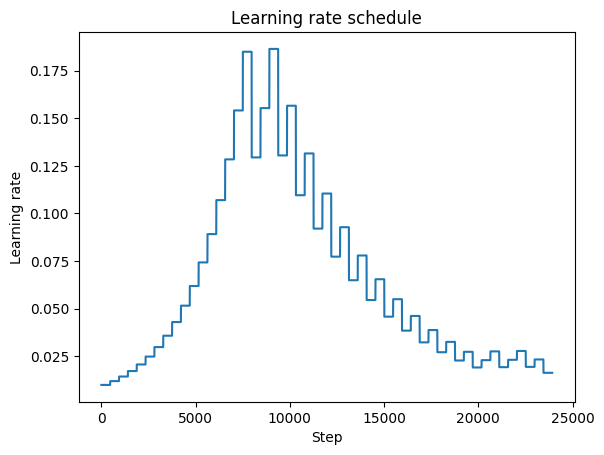

In [101]:
# Define metrics
train_loss = tf.keras.metrics.Mean()
train_acc = tf.keras.metrics.CategoricalAccuracy()
val_loss = tf.keras.metrics.Mean()
val_acc = tf.keras.metrics.CategoricalAccuracy()
train_loss_list = [100]
train_acc_list = []
val_loss_list = []
val_acc_list = []
lr_list = []
learning_goal = 0.95
# define loss function and optimizer
loss_func = loss_function
optimization = tf.keras.optimizers.SGD(learning_rate=0.01)

# Set hyperparameters
EPOCH = 100
LR_MIN = 1e-6
LR_MAX = 1.0
LR_FACTOR = 1.2
LR_FACTOR_MIN = 0.7
L2_LAMBDA = 1e-4
EPSILON = 1e-5
BATCH_SIZE = 128
BOUND = 50
EPSILON_ONE = 1e-7

# Train the model
for epoch in range(EPOCH):
    # Reset metrics
    train_loss.reset_states()
    train_acc.reset_states()
    val_loss.reset_states()
    val_acc.reset_states()
    
    # Train the model on the training set
    for step, (batch_x, batch_y) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            # compute predictions and loss
            logits = model(batch_x, training=True)
            loss = loss_func(batch_y, logits)

        # Calculate gradients and update weights
        gradients = tape.gradient(loss, model.trainable_variables)
        optimization.apply_gradients(zip(gradients, model.trainable_variables))

        # Update metrics
        train_loss(loss)
        train_acc(batch_y, logits)
        lr_list.append(optimization.learning_rate.numpy())
        
    
    # Evaluate the model on the validation set
    for batch_x, batch_y in test_dataset:
        # compute predictions and loss
        logits = model(batch_x, training=True)
        loss = loss_func(batch_y, logits)
        
        # Update metrics
        val_loss(loss)
        val_acc(batch_y, logits)
    
    
    # print epoch summary
    print(f"Epoch {epoch+1}:")
    print(f"  Training Loss: {train_loss.result():.4f}")
    print(f"  Training Accuracy: {train_acc.result():.4f}")
    print(f"  Validation Loss: {val_loss.result():.4f}")
    print(f"  Validation Accuracy: {val_acc.result():.4f}")
    
    # check if learning goal is achieved
    lg = 0
    for x, y in train_dataset:
        logits = model(x, training=False)
        loss = loss_func(y, logits)
        lg += loss.numpy()
    if lg/(len(train_dataset)*BATCH_SIZE) < EPSILON or epoch >= BOUND:
        break
    
    # Adjust learning rate
    if epoch >= BOUND or optimization.learning_rate.numpy() < EPSILON_ONE:
        break
    if epoch > 0 and train_loss.result() > train_loss_list[-1]:
        if optimization.learning_rate.numpy() > EPSILON_ONE:
            optimization.learning_rate.assign(optimization.learning_rate * LR_FACTOR_MIN)
        else:
            break
    else:
        if optimization.learning_rate.numpy() < LR_MAX:
            optimization.learning_rate.assign(optimization.learning_rate * LR_FACTOR)
    
    # record epoch metrics
    train_loss_list.append(train_loss.result().numpy())
    train_acc_list.append(train_acc.result().numpy())
    val_loss_list.append(val_loss.result().numpy())
    val_acc_list.append(val_acc.result().numpy())


# plot learning rate schedule
plt.plot(lr_list)
plt.title('Learning rate schedule')
plt.xlabel('Step')
plt.ylabel('Learning rate')
plt.show()


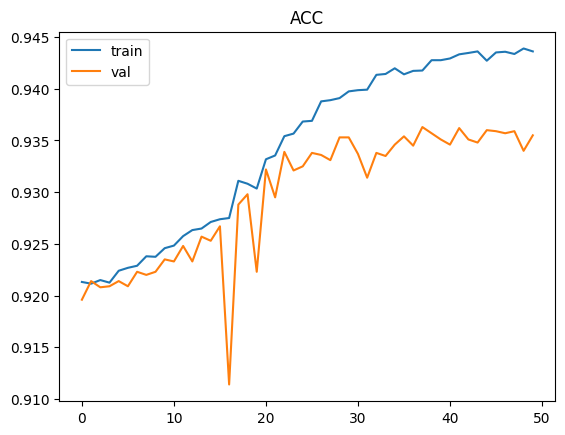

In [102]:
plt.plot(np.arange(0,len(train_acc_list)), train_acc_list, label='train')
plt.plot(np.arange(0,len(val_acc_list)), val_acc_list, label='val')
plt.title(label='ACC')
plt.legend()
plt.show()

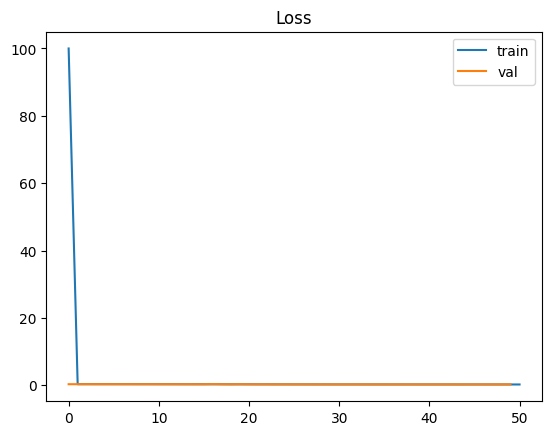

In [103]:
plt.plot(np.arange(0,len(train_loss_list)), train_loss_list, label='train')
plt.plot(np.arange(0,len(val_loss_list)), val_loss_list, label='val')
plt.title(label='Loss')
plt.legend()
plt.show()

### r_EB_LG_UA

Epoch 1:
  Training Loss: 0.2092
  Training Accuracy: 0.9440
  Validation Loss: 0.2335
  Validation Accuracy: 0.9353
Epoch 2:
  Training Loss: 0.2093
  Training Accuracy: 0.9442
  Validation Loss: 0.2332
  Validation Accuracy: 0.9366
Epoch 3:
  Training Loss: 0.2088
  Training Accuracy: 0.9447
  Validation Loss: 0.2335
  Validation Accuracy: 0.9359
Epoch 4:
  Training Loss: 0.2089
  Training Accuracy: 0.9444
  Validation Loss: 0.2325
  Validation Accuracy: 0.9352
Epoch 5:
  Training Loss: 0.2083
  Training Accuracy: 0.9445
  Validation Loss: 0.2327
  Validation Accuracy: 0.9361
Epoch 6:
  Training Loss: 0.2086
  Training Accuracy: 0.9447
  Validation Loss: 0.2328
  Validation Accuracy: 0.9367
Epoch 7:
  Training Loss: 0.2081
  Training Accuracy: 0.9449
  Validation Loss: 0.2336
  Validation Accuracy: 0.9361
Epoch 8:
  Training Loss: 0.2083
  Training Accuracy: 0.9446
  Validation Loss: 0.2326
  Validation Accuracy: 0.9357
Epoch 9:
  Training Loss: 0.2079
  Training Accuracy: 0.9448
  V

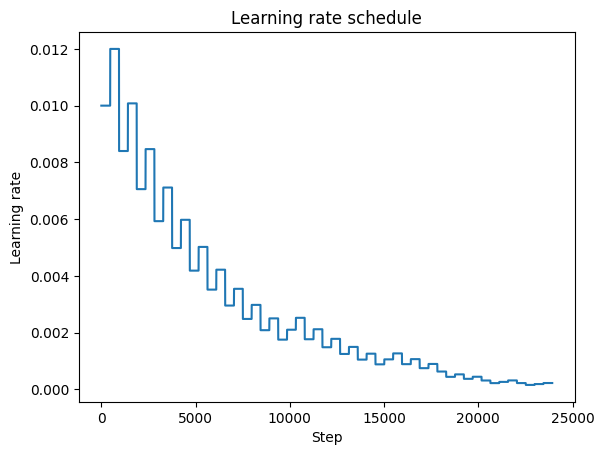

In [104]:
# Define metrics
train_loss = tf.keras.metrics.Mean()
train_acc = tf.keras.metrics.CategoricalAccuracy()
val_loss = tf.keras.metrics.Mean()
val_acc = tf.keras.metrics.CategoricalAccuracy()
train_loss_list = [100]
train_acc_list = []
val_loss_list = []
val_acc_list = []
lr_list = []
learning_goal = 0.95
# define loss function and optimizer
loss_func = loss_function
optimization = tf.keras.optimizers.SGD(learning_rate=0.01)

# Set hyperparameters
EPOCH = 100
LR_MIN = 1e-6
LR_MAX = 1.0
LR_FACTOR = 1.2
LR_FACTOR_MIN = 0.7
L2_LAMBDA = 1e-4
EPSILON = 1e-5
BATCH_SIZE = 128
BOUND = 50
EPSILON_ONE = 1e-7

with tf.device('/GPU:0'):
    # Train the model
    for epoch in range(EPOCH):
        # Reset metrics
        train_loss.reset_states()
        train_acc.reset_states()
        val_loss.reset_states()
        val_acc.reset_states()
    
        # Train the model on the training set
        for step, (batch_x, batch_y) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                # compute predictions and loss
                logits = model(batch_x, training=True)
                loss = loss_func(batch_y, logits)

            # Calculate gradients and update weights
            gradients = tape.gradient(loss, model.trainable_variables)
            optimization.apply_gradients(zip(gradients, model.trainable_variables))

            # Update metrics
            train_loss(loss)
            train_acc(batch_y, logits)
            lr_list.append(optimization.learning_rate.numpy())
        
    
        # Evaluate the model on the validation set
        for batch_x, batch_y in test_dataset:
            # compute predictions and loss
            logits = model(batch_x, training=True)
            loss = loss_func(batch_y, logits)
        
            # Update metrics
            val_loss(loss)
            val_acc(batch_y, logits)
    
    
        # print epoch summary
        print(f"Epoch {epoch+1}:")
        print(f"  Training Loss: {train_loss.result():.4f}")
        print(f"  Training Accuracy: {train_acc.result():.4f}")
        print(f"  Validation Loss: {val_loss.result():.4f}")
        print(f"  Validation Accuracy: {val_acc.result():.4f}")
    
        # check if learning goal is achieved
        lg = 0
        for x, y in train_dataset:
            logits = model(x, training=False)
            loss = loss_func(y, logits)
            lg += loss.numpy()
        if lg/(len(train_dataset)*BATCH_SIZE) < EPSILON or epoch >= BOUND:
            break
    
        # Adjust learning rate
        if epoch >= BOUND or optimization.learning_rate.numpy() < EPSILON_ONE:
            break
        if train_loss.result() > train_loss_list[-1]:
            if optimization.learning_rate.numpy() > EPSILON_ONE:
                optimization.learning_rate.assign(optimization.learning_rate * LR_FACTOR_MIN)
            else:
                break
        else:
            if optimization.learning_rate.numpy() < LR_MAX:
                optimization.learning_rate.assign(optimization.learning_rate * LR_FACTOR)
    
        # record epoch metrics
        train_loss_list.append(train_loss.result().numpy())
        train_acc_list.append(train_acc.result().numpy())
        val_loss_list.append(val_loss.result().numpy())
        val_acc_list.append(val_acc.result().numpy())


# plot learning rate schedule
plt.plot(lr_list)
plt.title('Learning rate schedule')
plt.xlabel('Step')
plt.ylabel('Learning rate')
plt.show()


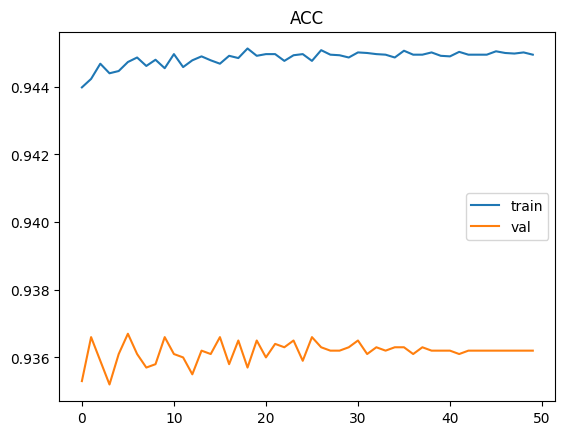

In [105]:
plt.plot(np.arange(0,len(train_acc_list)), train_acc_list, label='train')
plt.plot(np.arange(0,len(val_acc_list)), val_acc_list, label='val')
plt.title(label='ACC')
plt.legend()
plt.show()

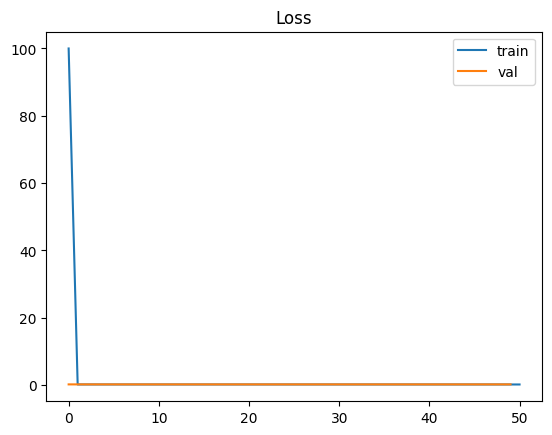

In [106]:
plt.plot(np.arange(0,len(train_loss_list)), train_loss_list, label='train')
plt.plot(np.arange(0,len(val_loss_list)), val_loss_list, label='val')
plt.title(label='Loss')
plt.legend()
plt.show()

### END